Notebook for initial development and testing for synthesizing FA models.

The user specifies a number of individuals we observe data from.  For each of these individuals, we create a random number of observed variables (e.g., neurons) and associate with each of these variables some random properties (e.g., position or genetic information) generated uniformly from the unit square. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.decomposition
import torch

from janelia_core.math.basic_functions import optimal_orthonormal_transform
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondGammaDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import Tanh
from janelia_core.visualization.image_generation import generate_2d_fcn_image
from janelia_core.visualization.matrix_visualization import cmp_n_mats
from janelia_core.ml.utils import torch_mod_to_fcn

from probabilistic_model_synthesis.fa import FAMdl
from probabilistic_model_synthesis.fa import Fitter
from probabilistic_model_synthesis.fa import generate_basic_posteriors
from probabilistic_model_synthesis.fa import generate_simple_prior_collection
from probabilistic_model_synthesis.fa import VICollection
from probabilistic_model_synthesis.math import MeanFcnTransformer
from probabilistic_model_synthesis.math import StdFcnTransformer
from probabilistic_model_synthesis.visualization import plot_torch_dist

## Parameters go here

In [4]:
# Number of individuals we simulate observing data from 
n_individuals = 3

# Range of the number of variables we observe from each individual - the actual number of variables we observe from an
# individual will be pulled uniformly from this range (inclusive)
n_var_range = [100, 120]

# Range of the number of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [1000, 1500]

# Number of latent variables in the model
n_latent_vars = 3

## Create the true prior distributions that relate parameters in the model to variable (e.g., neuron) properties

In [5]:
true_priors = generate_simple_prior_collection(n_prop_vars=2, n_latent_vars=n_latent_vars, 
                                               lm_mn_w_init_std=1.0, lm_std_w_init_std=.1,
                                               mn_mn_w_init_std=1.0, mn_std_w_init_std=1.0,
                                               psi_conc_f_w_init_std=2.0, psi_rate_f_w_init_std=1.0, 
                                               psi_conc_bias_mn=10.0, psi_rate_bias_mn=5.0)

## Generate properties

In [6]:
ind_n_vars = np.random.randint(n_var_range[0], n_var_range[1]+1, n_individuals)
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

## Generate true FA models

In [7]:
with torch.no_grad():
    ind_true_fa_mdls = [FAMdl(lm=true_priors.lm_prior.sample(props), mn=true_priors.mn_prior.sample(props).squeeze(), 
                           psi=(true_priors.psi_prior.sample(props).squeeze()))
                        for props in ind_props]

## Generate data from each model

In [8]:
with torch.no_grad():
    ind_data = [mdl.sample(n_smps) for n_smps, mdl in zip(ind_n_smps, ind_true_fa_mdls)]

## Fit new models together

In [9]:
fit_priors = generate_simple_prior_collection(n_prop_vars=2, n_latent_vars=n_latent_vars)
fit_posteriors = generate_basic_posteriors(n_obs_vars=ind_n_vars, n_smps=ind_n_smps, n_latent_vars=n_latent_vars)

fit_mdls = [FAMdl(lm=None, mn=None, psi=None) for i in range(n_individuals)]

vi_collections = [VICollection(data=data_i[1], props=props_i, mdl=mdl_i, posteriors=posteriors_i) 
                  for data_i, props_i,mdl_i, posteriors_i in zip(ind_data, ind_props, fit_mdls, fit_posteriors)]

## Set initial values of posteriors

In [10]:
fitter = Fitter(vi_collections=vi_collections, priors=fit_priors)

In [11]:
logs = [fitter.fit(3000, milestones=[100], update_int=100, init_lr=.1, skip_lm_kl=False, 
                 skip_mn_kl=False, skip_psi_kl=False) for fit_r in range(1)]


=========== EPOCH 0 COMPLETE ===========
Obj: 1.06e+06
----------------------------------------
NELL: 4.04e+05, 3.71e+05, 3.32e+05
Latent KL: 3.75e+01, 5.75e+01, 1.26e+01
LM KL: 6.36e+02, 7.23e+02, 7.19e+02
Mn KL: 2.11e+02, 2.45e+02, 2.40e+02
Psi KL: 3.23e+01, 3.71e+01, 3.78e+01
----------------------------------------
LR: 0.1

=========== EPOCH 100 COMPLETE ===========
Obj: 6.97e+05
----------------------------------------
NELL: 2.40e+05, 2.37e+05, 2.01e+05
Latent KL: 5.98e+03, 5.00e+03, 4.06e+03
LM KL: 5.15e+02, 5.86e+02, 5.50e+02
Mn KL: 3.23e+02, 3.47e+02, 3.43e+02
Psi KL: 2.96e+01, 3.51e+01, 4.54e+01
----------------------------------------
LR: 0.010000000000000002

=========== EPOCH 200 COMPLETE ===========
Obj: 6.94e+05
----------------------------------------
NELL: 2.41e+05, 2.35e+05, 2.00e+05
Latent KL: 5.87e+03, 4.97e+03, 4.05e+03
LM KL: 4.44e+02, 5.52e+02, 4.84e+02
Mn KL: 3.08e+02, 3.28e+02, 3.21e+02
Psi KL: 2.91e+01, 3.61e+01, 4.30e+01
--------------------------------------


=========== EPOCH 2400 COMPLETE ===========
Obj: 6.89e+05
----------------------------------------
NELL: 2.38e+05, 2.35e+05, 1.99e+05
Latent KL: 5.87e+03, 5.01e+03, 4.12e+03
LM KL: 2.63e+02, 2.61e+02, 2.33e+02
Mn KL: 2.80e+02, 2.98e+02, 3.03e+02
Psi KL: 3.72e+01, 4.56e+01, 5.30e+01
----------------------------------------
LR: 0.010000000000000002

=========== EPOCH 2500 COMPLETE ===========
Obj: 6.88e+05
----------------------------------------
NELL: 2.39e+05, 2.34e+05, 1.98e+05
Latent KL: 5.99e+03, 4.89e+03, 4.23e+03
LM KL: 2.62e+02, 2.60e+02, 2.41e+02
Mn KL: 2.80e+02, 3.00e+02, 3.04e+02
Psi KL: 3.75e+01, 4.62e+01, 5.38e+01
----------------------------------------
LR: 0.010000000000000002

=========== EPOCH 2600 COMPLETE ===========
Obj: 6.89e+05
----------------------------------------
NELL: 2.38e+05, 2.34e+05, 1.99e+05
Latent KL: 5.95e+03, 4.95e+03, 4.10e+03
LM KL: 2.63e+02, 2.62e+02, 2.34e+02
Mn KL: 2.81e+02, 3.00e+02, 3.04e+02
Psi KL: 3.80e+01, 4.61e+01, 5.40e+01
----------------

## Examine lots of fitting performance

<IPython.core.display.Javascript object>


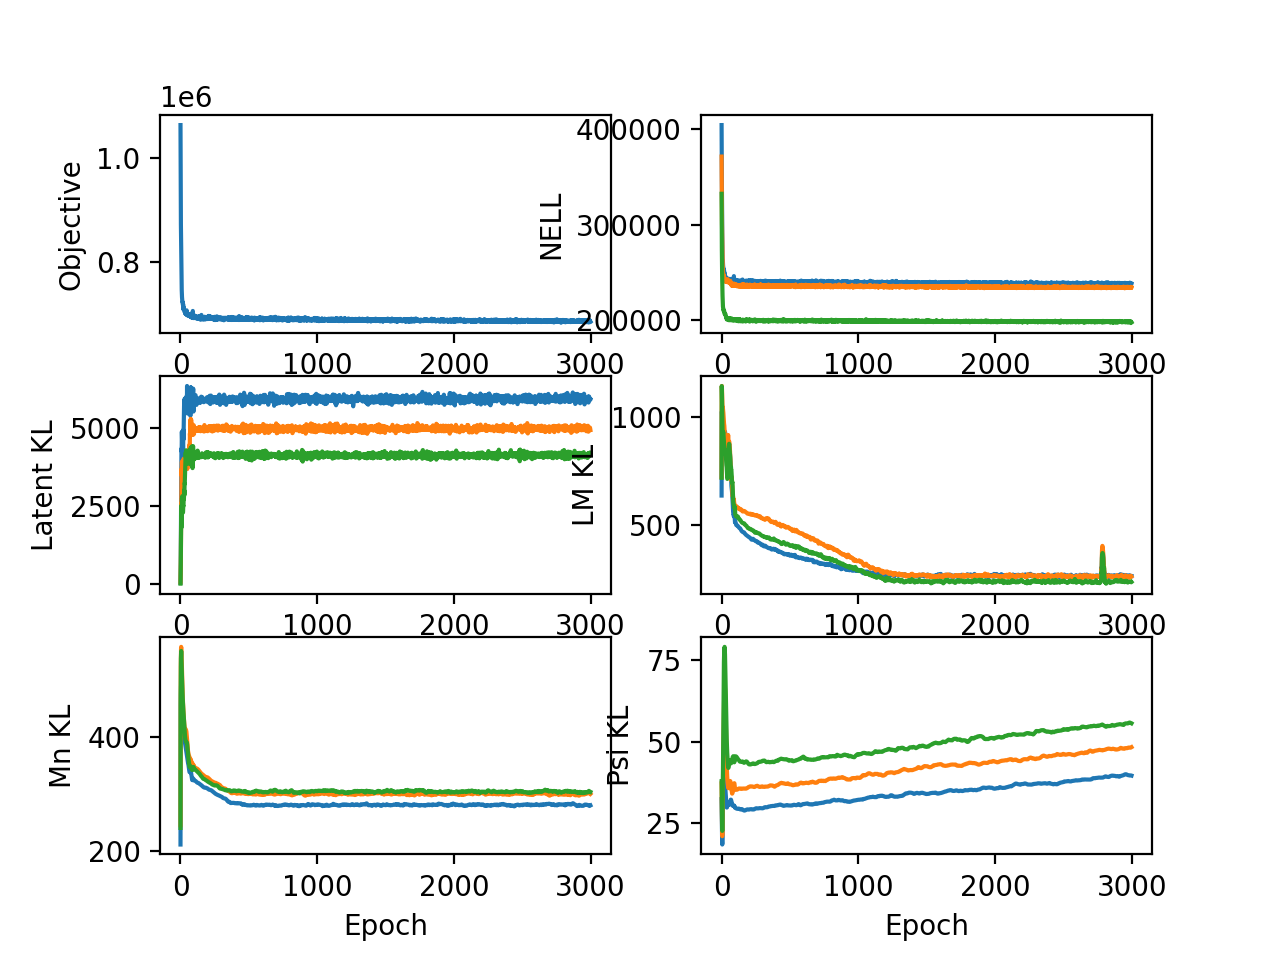

In [105]:
fitter.plot_log(logs[0])

## Look at model fits

In [13]:
exam_mdl = 2

<IPython.core.display.Javascript object>


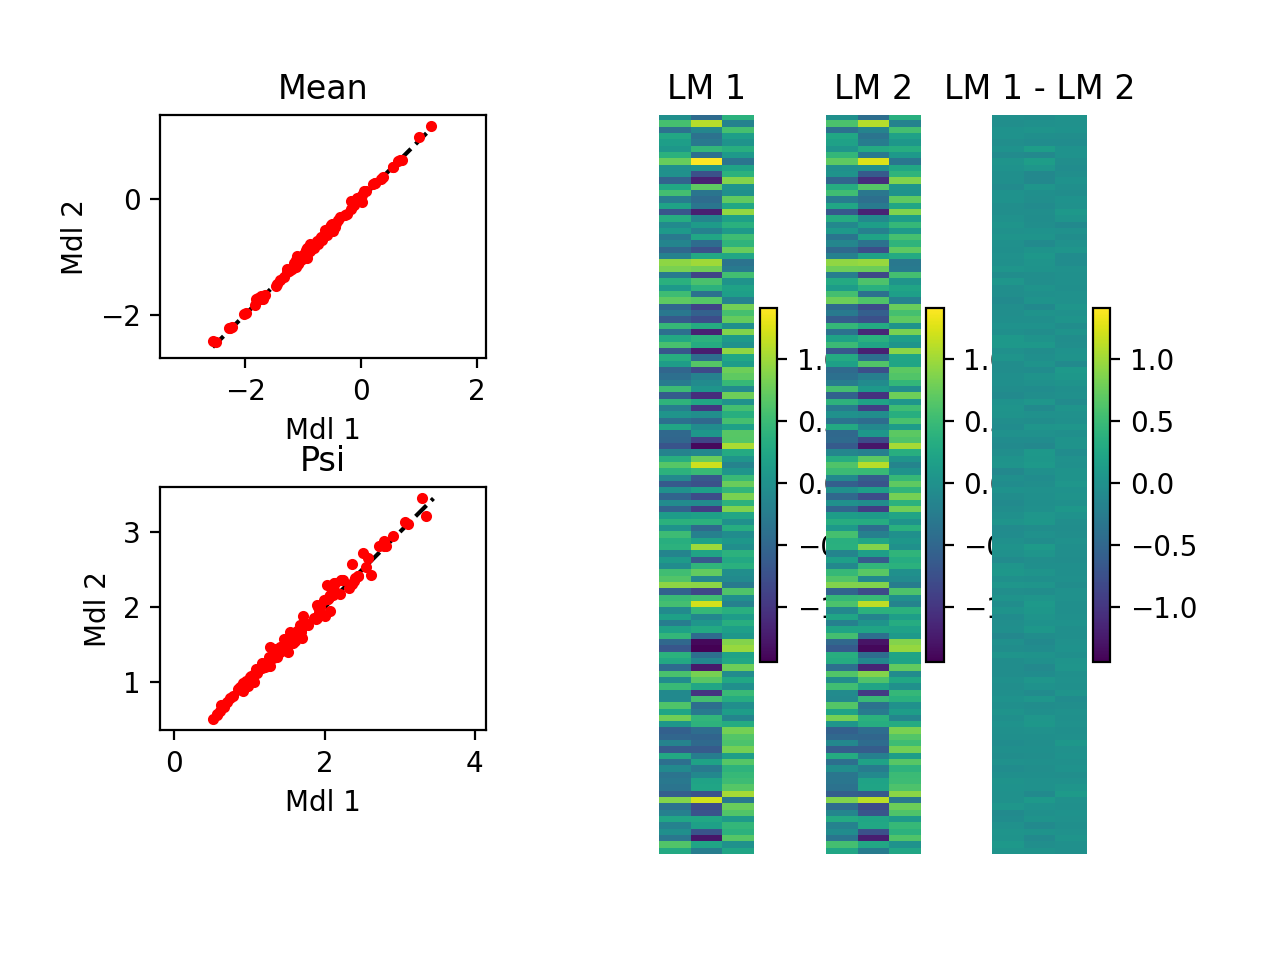

(117, 3)


In [15]:
fit_lm = vi_collections[exam_mdl].posteriors.lm_post(ind_props[exam_mdl]).detach().squeeze()
fit_mn = vi_collections[exam_mdl].posteriors.mn_post(ind_props[exam_mdl]).detach().squeeze()
fit_psi = vi_collections[exam_mdl].posteriors.psi_post.mode(ind_props[exam_mdl]).detach().squeeze()
#fit_psi = vi_collections[exam_mdl].mdl.psi

cmp_mdl = FAMdl(lm=fit_lm, mn=fit_mn, psi=fit_psi)
true_mdl = ind_true_fa_mdls[exam_mdl]

plt.figure()
true_mdl.compare_models(true_mdl, cmp_mdl)

### Visualize paraemters of the true prior distributions over the loading matrices

<IPython.core.display.Javascript object>


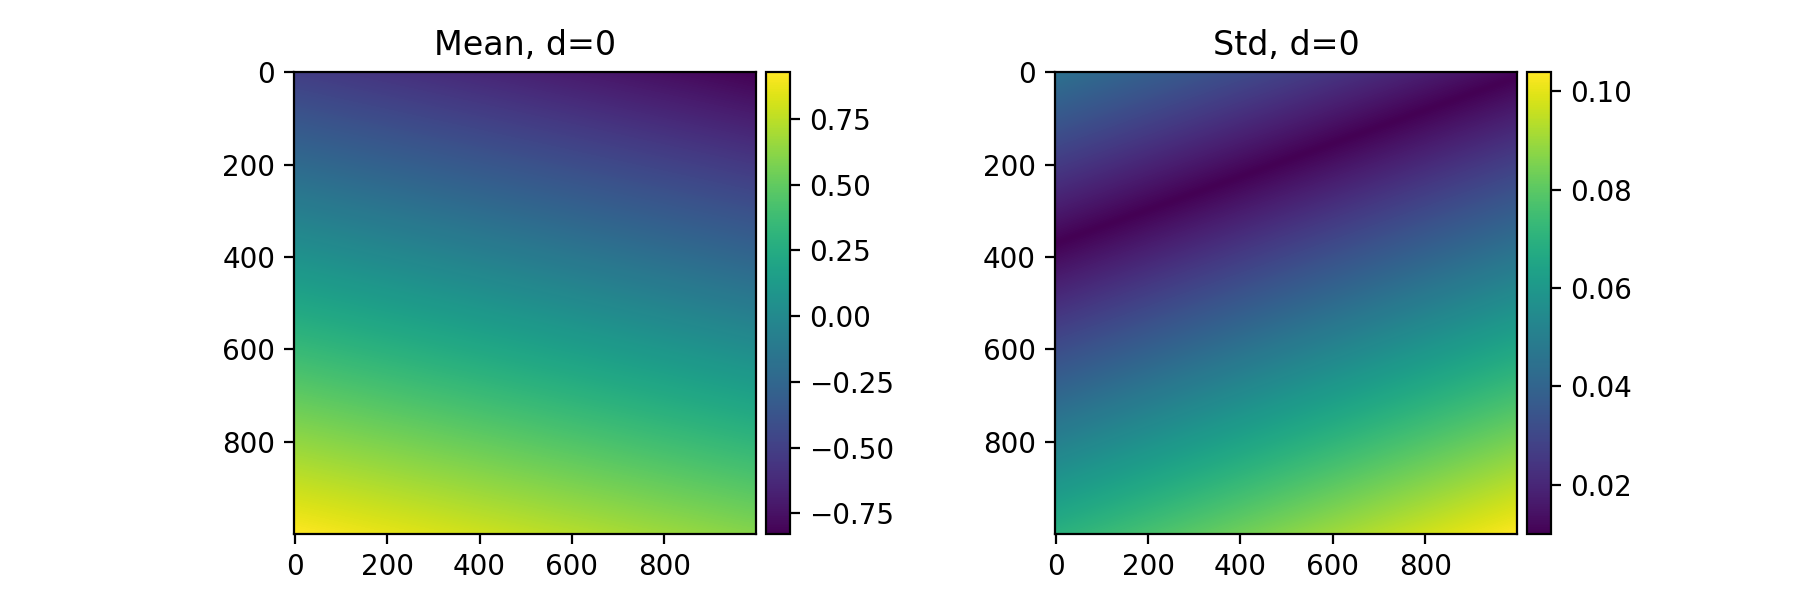

<IPython.core.display.Javascript object>


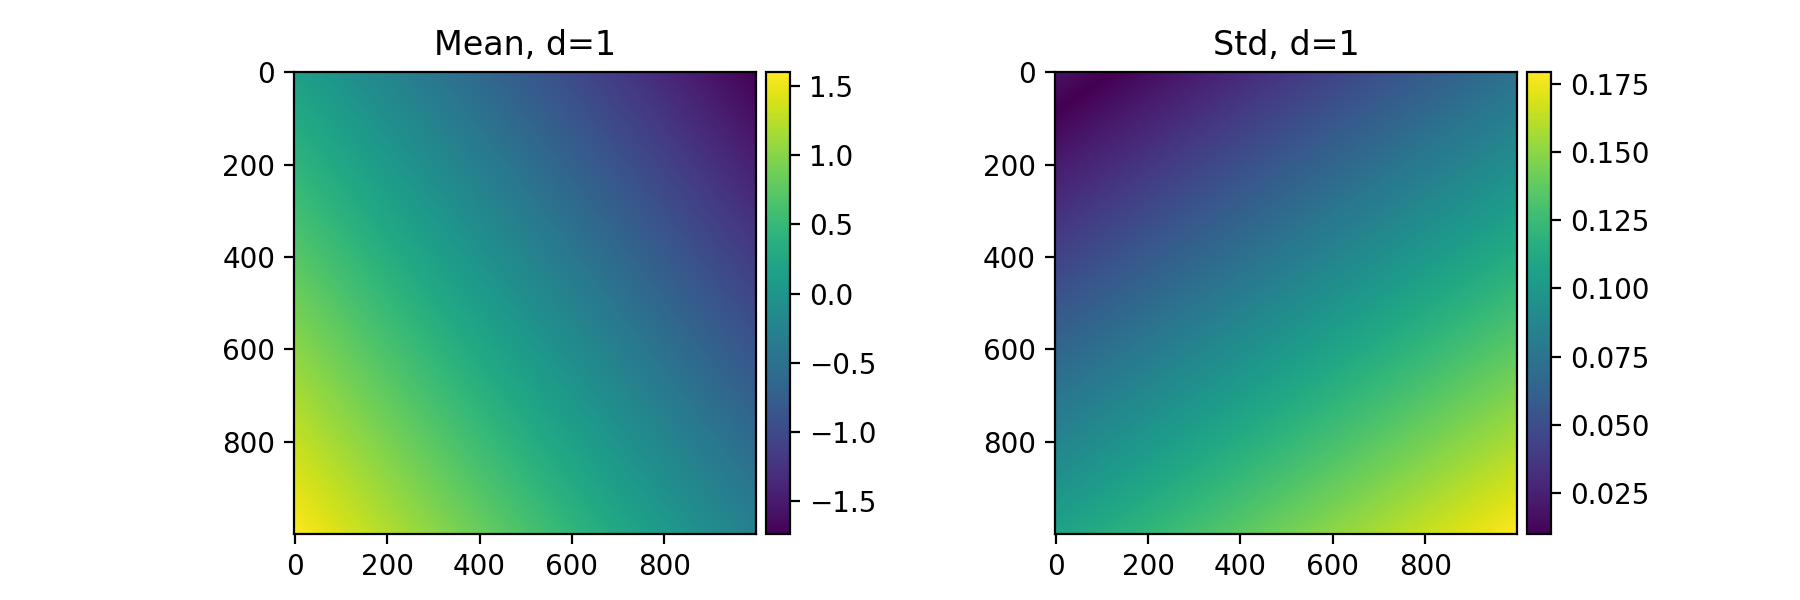

<IPython.core.display.Javascript object>


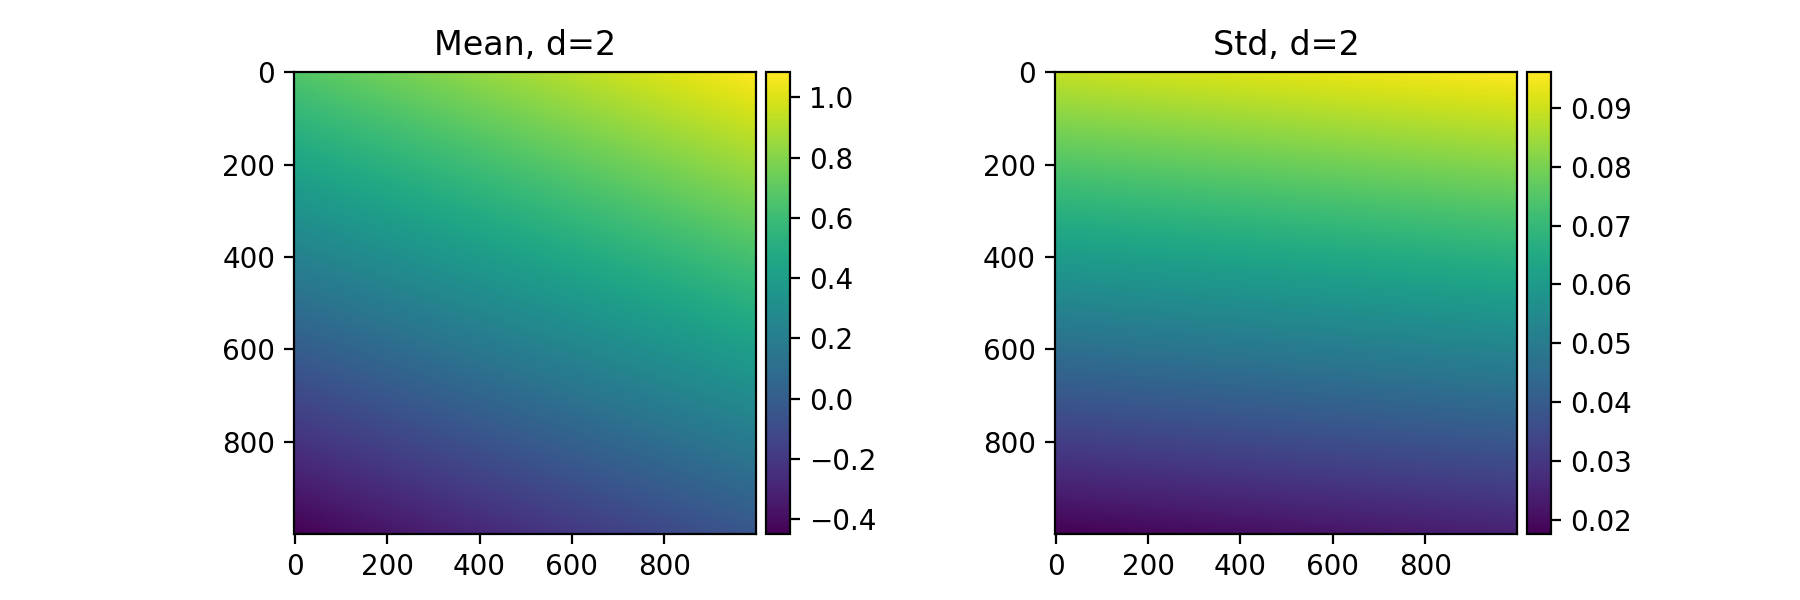

In [102]:
for d in range(n_latent_vars):
    plt.figure(figsize=(9,3))
    plot_torch_dist(mn_f=true_priors.lm_prior.mn_f, std_f=true_priors.lm_prior.std_f, vis_dim=d, 
                    extra_title_str = ', d=' + str(d))

### Visualize paraemters of the fit prior distributions over the loading matrices

In [103]:
rnd_vls = torch.rand(1000,2)
o = optimal_orthonormal_transform(true_priors.lm_prior(rnd_vls).detach().numpy(), 
                                  fit_priors.lm_prior(rnd_vls).detach().numpy())
fit_lm_mn_fcn = MeanFcnTransformer(o=o.transpose(), f=fit_priors.lm_prior.mn_f)
fit_lm_std_fcn = StdFcnTransformer(o=o.transpose(), f=fit_priors.lm_prior.std_f)

<IPython.core.display.Javascript object>


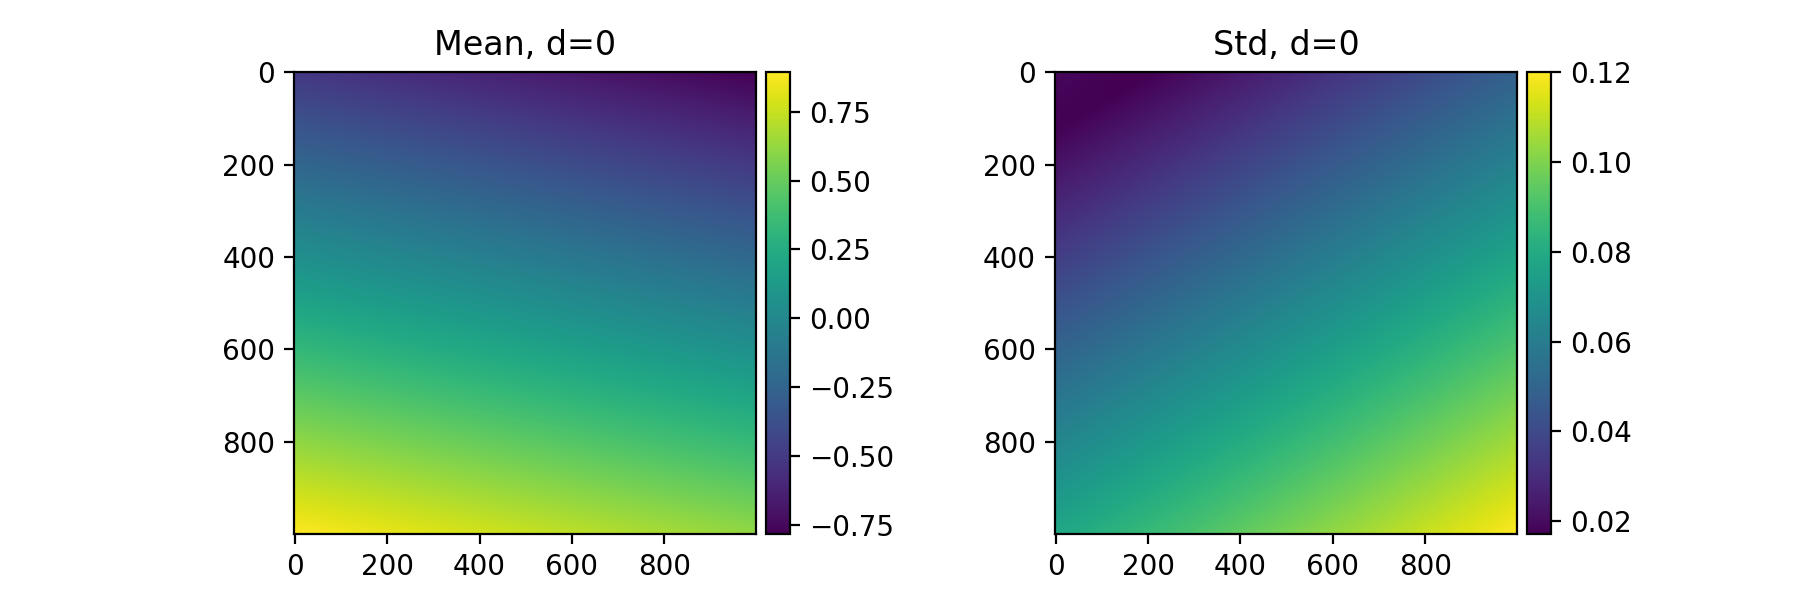

torch.Size([1000000, 3])


<IPython.core.display.Javascript object>


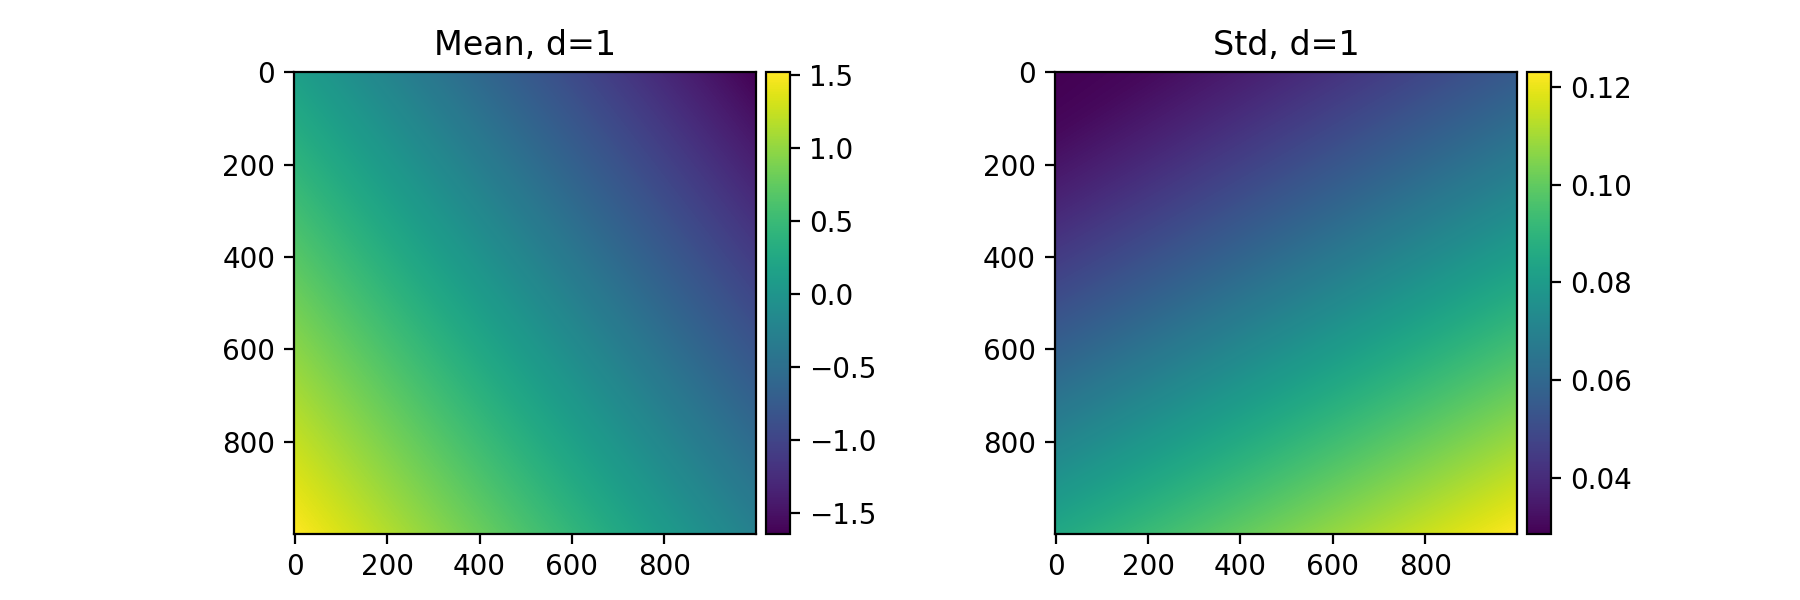

torch.Size([1000000, 3])


<IPython.core.display.Javascript object>


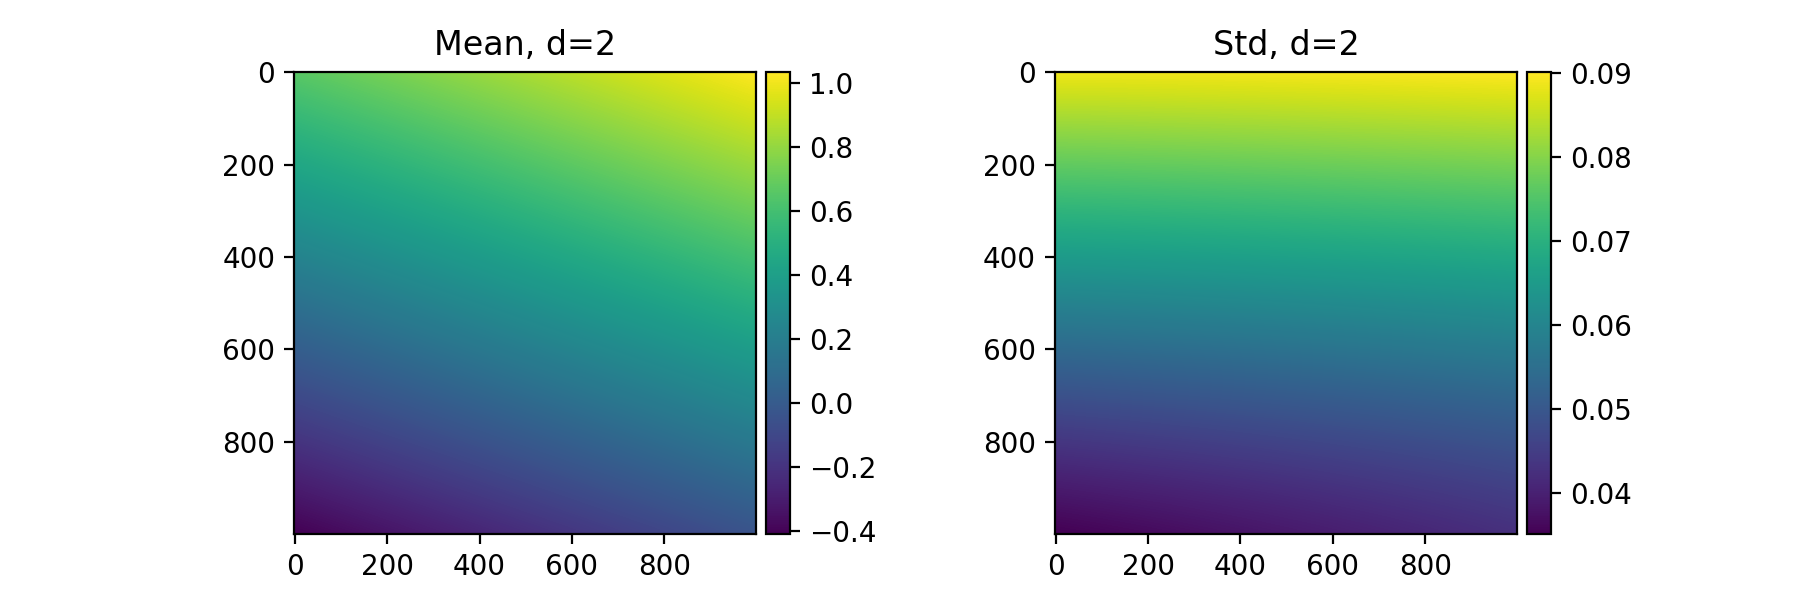

torch.Size([1000000, 3])


In [104]:
for d in range(n_latent_vars):
    plt.figure(figsize=(9,3))
    plot_torch_dist(mn_f=fit_lm_mn_fcn, std_f=fit_lm_std_fcn, vis_dim=d, 
                    extra_title_str = ', d=' + str(d))

### Visualize parameters of the true prior distribution over the means

<IPython.core.display.Javascript object>


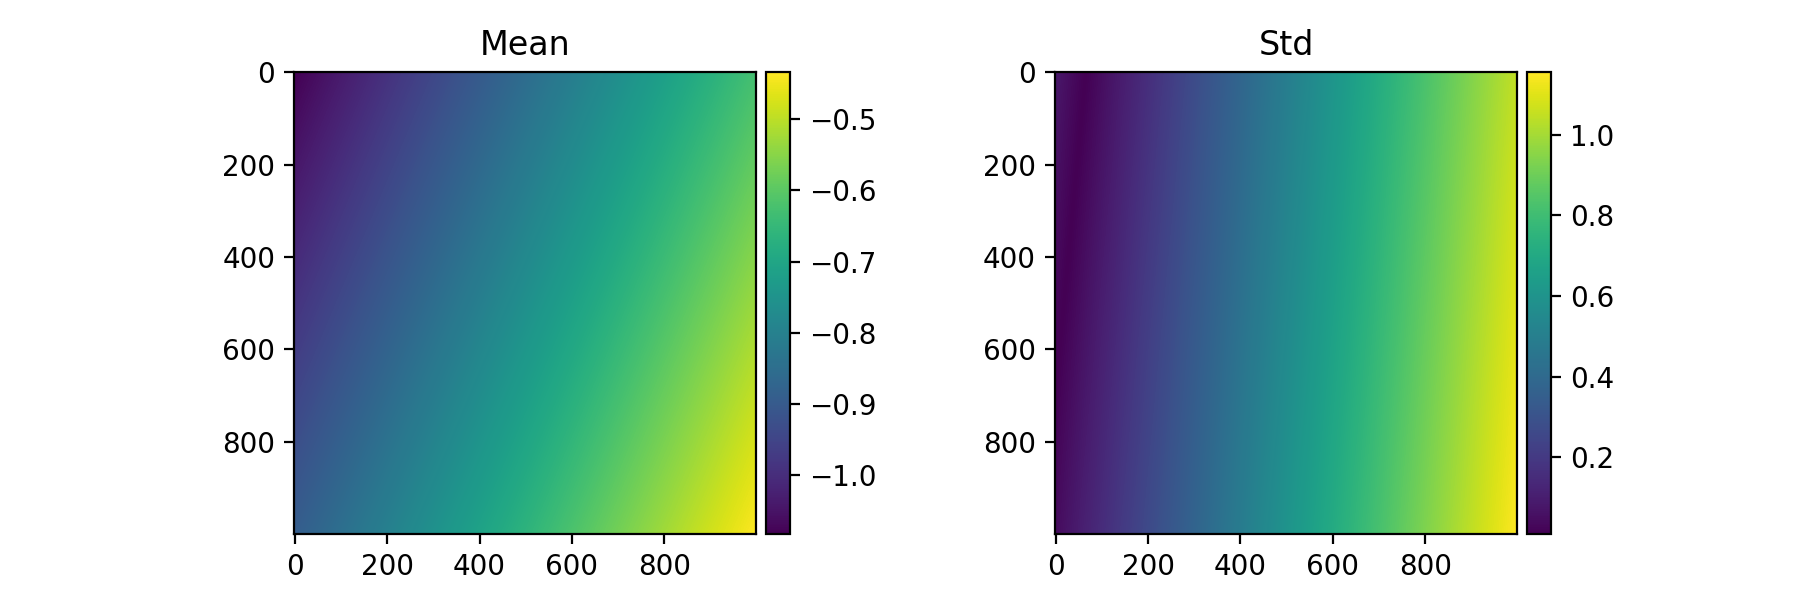

In [26]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=true_priors.mn_prior.mn_f, std_f=true_priors.mn_prior.std_f)

### Visualize parameters of the fit prior distribution over the means

<IPython.core.display.Javascript object>


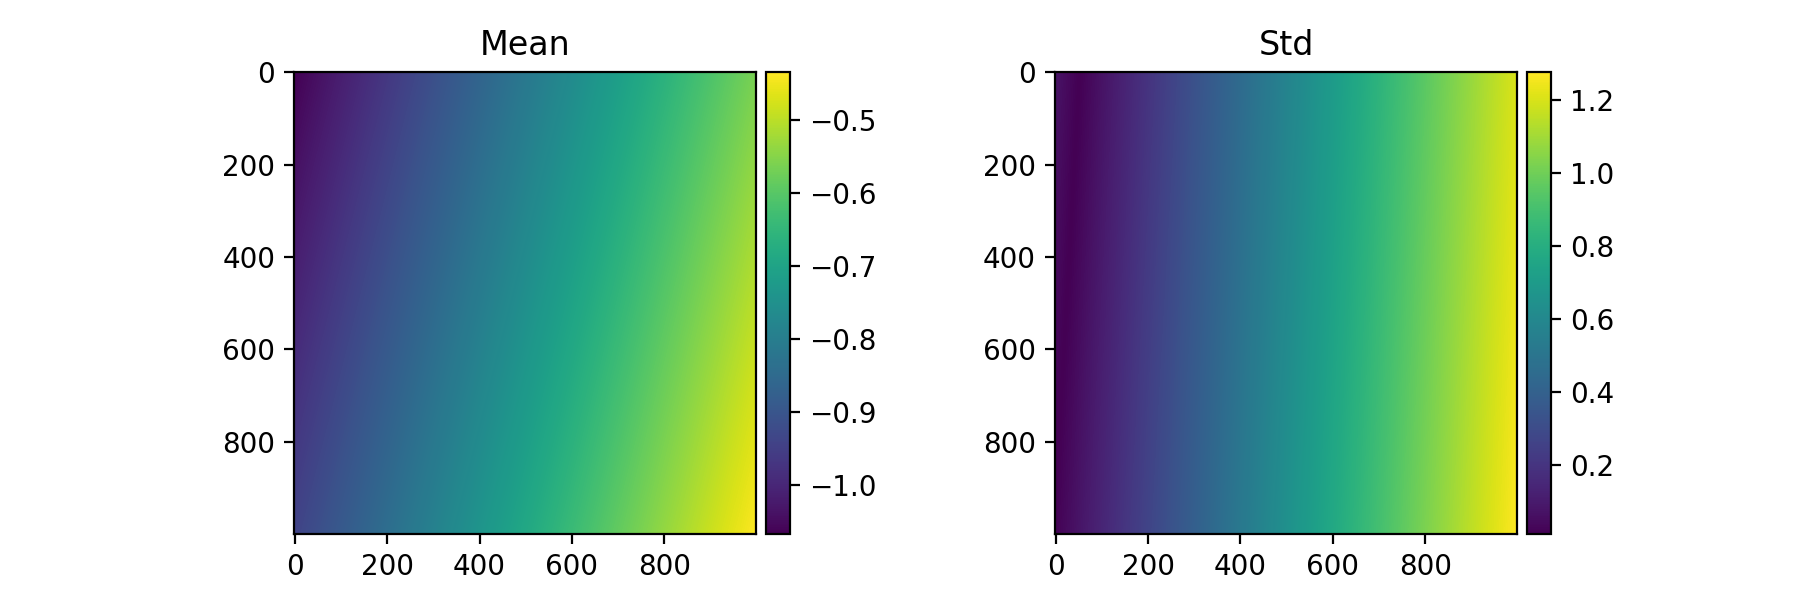

In [18]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=fit_priors.mn_prior.mn_f, std_f=fit_priors.mn_prior.std_f)

### Visualize parameters of the true prior distribution over private variances

<IPython.core.display.Javascript object>


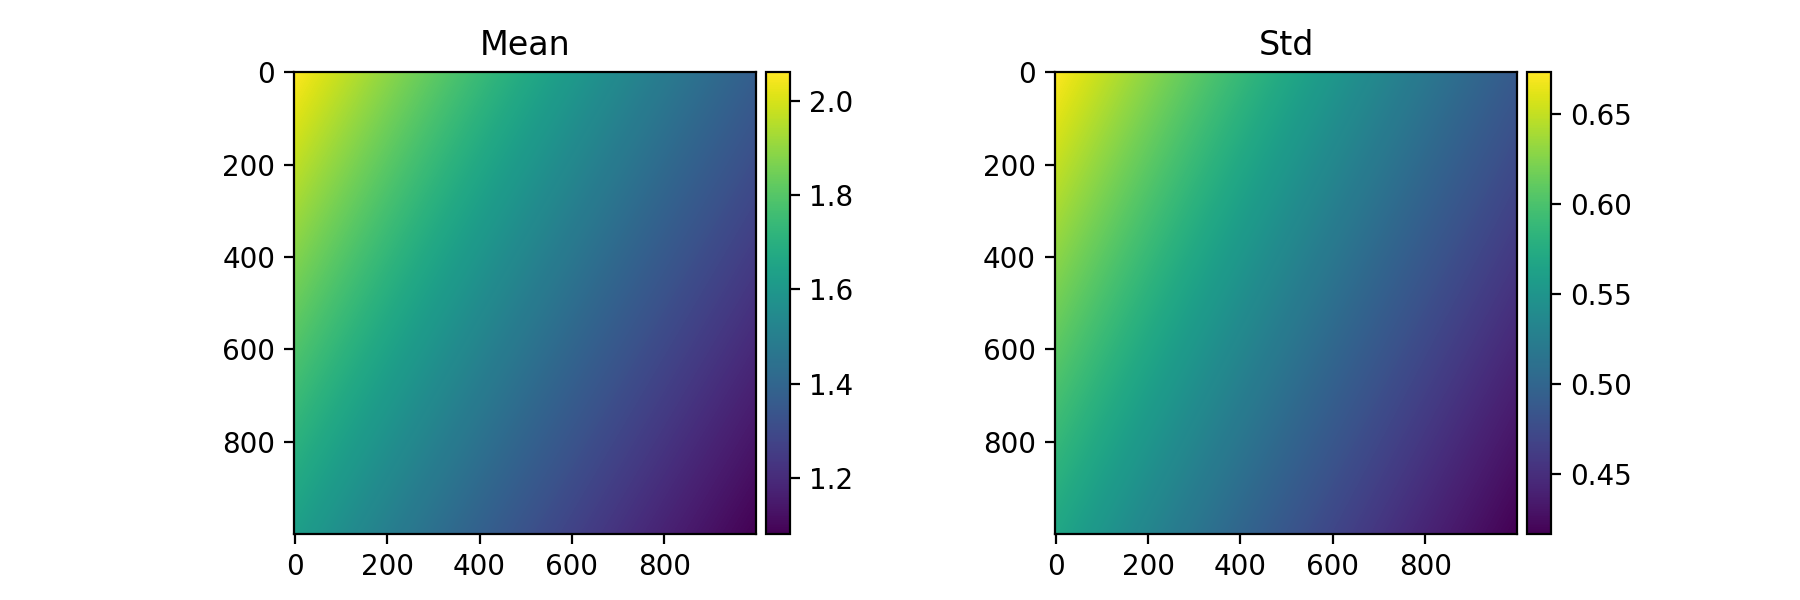

In [19]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=true_priors.psi_prior.forward, std_f=true_priors.psi_prior.std)

### Visualize parameters of the fit prior distribution over private variances

<IPython.core.display.Javascript object>


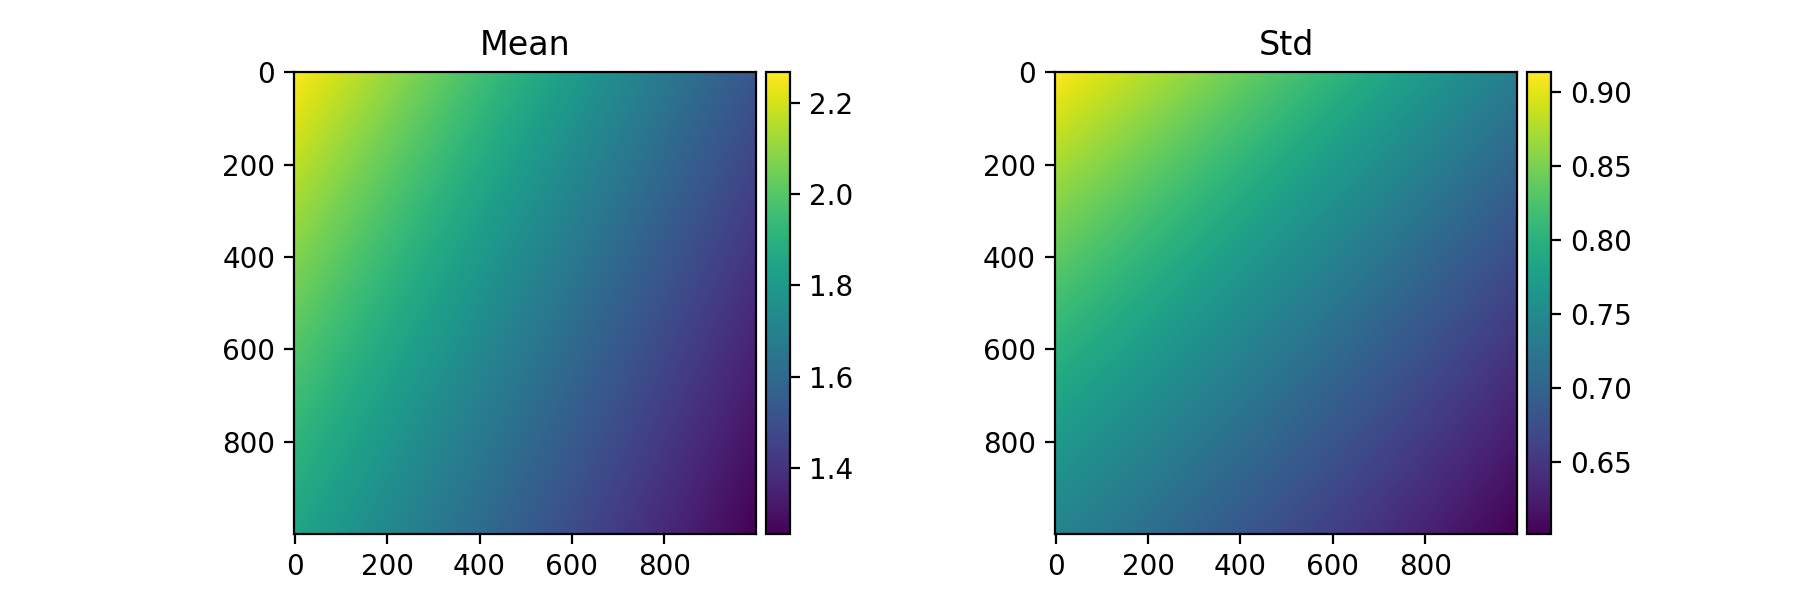

In [20]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=fit_priors.psi_prior.forward, std_f=fit_priors.psi_prior.std)